# What people say about Amazon Products
by Robert Ayub Odhiambo (http://www.a4ayub.me)

## Background

Reviews are an important part of any platform where users engage. E-Commerce applications provide an added advantage to customers to buy a product with added suggestions in the form of reviews

**How do reviews help**

1. Improves credibility
2. Helps users in making a decision to buy a product or not
3. Boosts the sales for products which are good in real
4. Increases customer life time value

## The Problem

The enormous amount of reviews create problems for customers as they are not able to seggregate useful ones and make it extremely difficult to filter out informative reviews.

## The Proposed Solution

This notebook attempts to rank reviews based on their relevance with specific product in this case Home Internet while at the same time ranking down irrelevant reviews

## Approach

It is easy to classify whether a review is useful or not. However, ranking reviews on the basis of usefulness, is a complex task. Our ranking methodology is based on this information.

Splitting the dataset into two sets:
1. **Set 0** - These are reviews that are not informative, these include reviews based on delivery, customer support, packaging e.t.c and they do not exactly describe the product
2. **Set 1** - These are reviews that are informative and are better than all reviews in set 0

Something worth noting is that any review in Set 1 should always be better than all reviews of Set 0 and vice versa

**Assumption**
- From the amazon dataset, we will assume the number of up-votes for helpfulness signify relevant reviews. Depending on the rating score,we will consider a rating of five to be relevant and helpful review and anything below 5 not to be relevant and helpful

**The Workflow**
1. Label the dataset based on the relevance upvotes
2. Features Extraction
3. Pairwise Ranking
4. Classification
5. Rank on basis of relevance

## Workbench

### Import the files

In [60]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pylab import rcParams
from copy import deepcopy
import seaborn as sns

import sys
sys.path.append('./utils')
from utils import review_feature
rf = review_feature()
%matplotlib inline

# modelling libraries
from joblib import load, dump
from copy import deepcopy
from statistics import mean

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows',1000)
rcParams['figure.figsize'] = 18,12

### Create the dataframe from the csv

In [3]:
# Import the data
reviews_df = pd.read_csv("datasets/amazon_customer_reviews.csv",engine="python");

In [4]:
#check the shape
print("We have {} rows and {} columns of customer reviews.".format(reviews_df.shape[0],reviews_df.shape[1]))

We have 28332 rows and 24 columns of customer reviews.


In [5]:
# Because of memory resources during the processing of the ranking later in this notebook. A reduced dataset of 1,500 is created
reviews_df = reviews_df.sample(1500)

In [6]:
# check the info
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 1438 to 18102
Data columns (total 24 columns):
id                     1500 non-null object
dateAdded              1500 non-null object
dateUpdated            1500 non-null object
name                   1500 non-null object
asins                  1500 non-null object
brand                  1500 non-null object
categories             1500 non-null object
primaryCategories      1500 non-null object
imageURLs              1500 non-null object
keys                   1500 non-null object
manufacturer           1500 non-null object
manufacturerNumber     1500 non-null object
reviews.date           1500 non-null object
reviews.dateSeen       1500 non-null object
reviews.didPurchase    1 non-null object
reviews.doRecommend    858 non-null object
reviews.id             1 non-null float64
reviews.numHelpful     859 non-null float64
reviews.rating         1500 non-null int64
reviews.sourceURLs     1500 non-null object
reviews.text    

In [7]:
# select only the necessary fields
reviews_df = reviews_df[["name","reviews.rating","reviews.text"]]
reviews_df.head()

name  \
1438   AmazonBasics AAA Performance Alkaline Batteries (36 Count)                                    
26133  Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers             
13634  Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Pink Kid-Proof Case                        
20256  All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Special Offers   
2116   AmazonBasics AAA Performance Alkaline Batteries (36 Count)                                    

       reviews.rating  \
1438   5                
26133  5                
13634  5                
20256  5                
2116   5                

                                                                 reviews.text  
1438   Battery last long!                                                      
26133  my kids enjoy the Fire HD and they love the picture quality             
13634  My niece loved it! I love that it is designed especially for kids. She  
20256  Ordered this for my nephew and he loves it. Great Price too !!          
2116   Great

In [8]:
# check the rating values
reviews_df["reviews.rating"].value_counts()

5    1055
4    289 
3    67  
1    60  
2    29  
Name: reviews.rating, dtype: int64

In [9]:
# check the product values
reviews_group_by_name = reviews_df.groupby(['name','reviews.rating'])
reviews_group_by_name_df = pd.DataFrame({'count':reviews_group_by_name.size()}).reset_index()


In [10]:
reviews_group_by_name_df.head()

name  \
0  All-New Fire 7 Tablet with Alexa, 7" Display, 8 GB - Marine Blue                  
1  All-New Fire 7 Tablet with Alexa, 7" Display, 8 GB - Marine Blue                  
2  All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Blue Kid-Proof Case   
3  All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Blue Kid-Proof Case   
4  All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Blue Kid-Proof Case   

   reviews.rating  count  
0  4               1      
1  5               2      
2  3               1      
3  4               3      
4  5               9

In [11]:
reviews_group_by_name_df.sort_values(by='count',ascending=False)

name  \
48  AmazonBasics AAA Performance Alkaline Batteries (36 Count)                                                                                     
43  AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary                                                                 
17  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black                                                          
60  Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers                                                              
47  AmazonBasics AAA Performance Alkaline Batteries (36 Count)                                                                                     
75  Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Pink Kid-Proof Case                                                                         
66  Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case                                                                         
70  Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case                                                                        
79  Fire Tablet with Alexa, 7 Display, 16 GB, Blue - with Special Offers                                                                           
59  Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers                                                              
88  Fire Tablet, 7 Display, Wi-Fi, 16 GB - Includes Special Offers, Black                                                                          
84  Fire Tablet with Alexa, 7 Display, 16 GB, Magenta - with Special Offers                                                                        
11  All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Special Offers                                                    
44  AmazonBasics AAA Performance Alkaline Batteries (36 Count)                                                                                     
46  AmazonBasics AAA Performance Alkaline Batteries (36 Count)                                                                                     
74  Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Pink Kid-Proof Case                                                                         
96  Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
42  AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary                                                                 
16  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black                                                          
37  Amazon Tap Smart Assistant Alexaenabled (black) Brand New                                                                                      
65  Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case                                                                         
78  Fire Tablet with Alexa, 7 Display, 16 GB, Blue - with Special Offers                                                                           
45  AmazonBasics AAA Performance Alkaline Batteries (36 Count)                                                                                     
69  Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case                                                                        
39  AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary                                                                 
8   All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Pink Kid-Proof Case                                                                
83  Fire Tablet with Alexa, 7 Display, 16 GB, Magenta - with Special Offers                                                                     

In [12]:
# filter out reviews with count greater than 100
reviews_with_100_or_more_interactions_df = reviews_group_by_name_df[reviews_group_by_name_df['count'] >= 100]
reviews_with_100_or_more_interactions_df.sort_values(by='count',ascending=False)

name  \
48  AmazonBasics AAA Performance Alkaline Batteries (36 Count)                       
43  AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary   

    reviews.rating  count  
48  5               320    
43  5               133

In [13]:
reviews_with_100_or_more_interactions_df["reviews.rating"].value_counts()

5    2
Name: reviews.rating, dtype: int64

In [14]:
# Get the reviews for the above products
products_list = [
    "AmazonBasics AAA Performance Alkaline Batteries (36 Count)	",
    "AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary",
    "Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers",
    "All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black",
    "Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Pink Kid-Proof Case",
    "Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case",
    "AmazonBasics AAA Performance Alkaline Batteries (36 Count)",
    "Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case",
    "Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers",
    "All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black",
    "Fire Tablet, 7 Display, Wi-Fi, 16 GB - Includes Special Offers, Black",
    "Fire Tablet with Alexa, 7 Display, 16 GB, Blue - with Special Offers",
    "All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Special Offers",
    "AmazonBasics AAA Performance Alkaline Batteries (36 Count)",
    "Fire Tablet with Alexa, 7 Display, 16 GB, Magenta - with Special Offers",
    "AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary",
    "Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Pink Kid-Proof Case",
    "Amazon Tap Smart Assistant Alexaenabled (black) Brand New",
    "Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers",
    "AmazonBasics AAA Performance Alkaline Batteries (36 Count)",
    "Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case",
    "Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case",
    "Fire Tablet, 7 Display, Wi-Fi, 16 GB - Includes Special Offers, Black",
    "Fire Tablet with Alexa, 7 Display, 16 GB, Blue - with Special Offers",
    "AmazonBasics AAA Performance Alkaline Batteries (36 Count)",
    "All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Special Offers",
    "Fire Tablet with Alexa, 7 Display, 16 GB, Magenta - with Special Offers",
    "AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary",
    "All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Pink Kid-Proof Case",
    "Kindle E-reader - White, 6 Glare-Free Touchscreen Display, Wi-Fi - Includes Special Offers",
    "All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Blue Kid-Proof Case",
    "AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary",
    "Amazon Tap Smart Assistant Alexaenabled (black) Brand New",
    "AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary",
    "All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Marine Blue - with Special Offers",
    "All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Blue",
    "Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Tangerine - with Special Offers"
]

selected_reviews_df = reviews_df[reviews_df.name.isin(products_list)]

In [15]:
selected_reviews_df.head()

name  \
1438   AmazonBasics AAA Performance Alkaline Batteries (36 Count)                                    
26133  Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers             
13634  Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Pink Kid-Proof Case                        
20256  All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Special Offers   
2116   AmazonBasics AAA Performance Alkaline Batteries (36 Count)                                    

       reviews.rating  \
1438   5                
26133  5                
13634  5                
20256  5                
2116   5                

                                                                 reviews.text  
1438   Battery last long!                                                      
26133  my kids enjoy the Fire HD and they love the picture quality             
13634  My niece loved it! I love that it is designed especially for kids. She  
20256  Ordered this for my nephew and he loves it. Great Price too !!          
2116   Great

In [16]:
# confirm that we have 37 records
selected_reviews_df.shape

(1440, 3)

In [17]:
selected_reviews_df["reviews.rating"].value_counts()

5    1011
4    274 
3    67  
1    59  
2    29  
Name: reviews.rating, dtype: int64

In [18]:
# Assuming that a rating of 5 is synonymous to a good review and anything else is not a relevant review then we can 
#create a new dataframe with only two labels
rating_mapping_dict = {5 : 1 , 4 : 0, 3 : 0, 2 : 0, 1 : 0}
selected_reviews_df["reviews.rating"] = selected_reviews_df["reviews.rating"].map(rating_mapping_dict)

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [19]:
selected_reviews_df["reviews.rating"].value_counts()

1    1011
0    429 
Name: reviews.rating, dtype: int64

In [20]:
# Label Analysis using crosstab
label_analysis = pd.crosstab(selected_reviews_df["name"],selected_reviews_df["reviews.rating"],margins="All")
label_analysis

reviews.rating                                                                                                                                  0  \
name                                                                                                                                                
All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Blue Kid-Proof Case                                                               4     
All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Pink Kid-Proof Case                                                               5     
All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Special Offers                                                   11    
All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Marine Blue - with Special Offers                                                   2     
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black                                                         27    
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Blue                                                          2     
Amazon Tap Smart Assistant Alexaenabled (black) Brand New                                                                                     10    
AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary                                                                50    
AmazonBasics AAA Performance Alkaline Batteries (36 Count)                                                                                    129   
Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers                                                             43    
Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Tangerine - with Special Offers                                                             1     
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case                                                                        24    
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case                                                                       21    
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Pink Kid-Proof Case                                                                        34    
Fire Tablet with Alexa, 7 Display, 16 GB, Blue - with Special Offers                                                                          20    
Fire Tablet with Alexa, 7 Display, 16 GB, Magenta - with Special Offers                                                                       15    
Fire Tablet, 7 Display, Wi-Fi, 16 GB - Includes Special Offers, Black                                                                         16    
Kindle E-reader - White, 6 Glare-Free Touchscreen Display, Wi-Fi - Includes Special Offers                                                    9     
Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers  6     
All                                                                                                                                           429   

reviews.rating                                                                                                                                   1  \
name                                                                                                                                                 
All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Blue Kid-Proof Case                                                               9      
All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Pink Kid-Proof Case                                                               10     
All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Special Offers                              

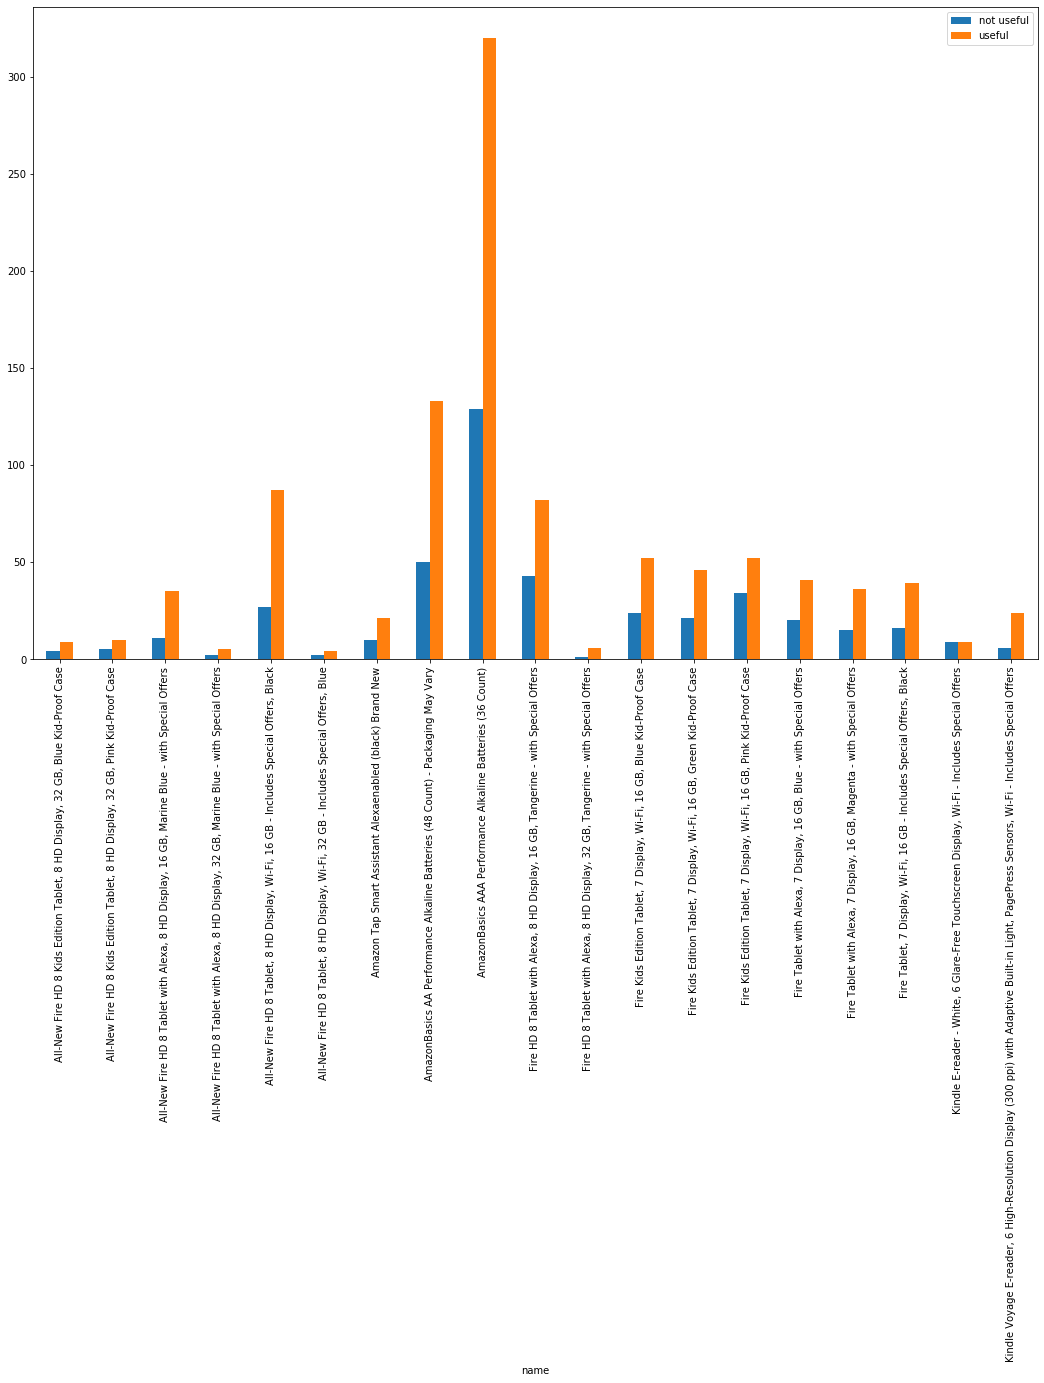

In [21]:
# Tabulation of Crostab
analysis = label_analysis.reset_index()
analysis.columns = ["name","not useful","useful","All"]
analysis.iloc[:-1].plot(x="name",y=["not useful","useful"],kind="bar")

In [22]:
# Check the length of the reviews
selected_reviews_df["review_length"] = selected_reviews_df["reviews.text"].apply(lambda x: len(x.split()))

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [23]:
selected_reviews_df.head()

name  \
1438   AmazonBasics AAA Performance Alkaline Batteries (36 Count)                                    
26133  Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers             
13634  Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Pink Kid-Proof Case                        
20256  All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Special Offers   
2116   AmazonBasics AAA Performance Alkaline Batteries (36 Count)                                    

       reviews.rating  \
1438   1                
26133  1                
13634  1                
20256  1                
2116   1                

                                                                 reviews.text  \
1438   Battery last long!                                                       
26133  my kids enjoy the Fire HD and they love the picture quality              
13634  My niece loved it! I love that it is designed especially for kids. She   
20256  Ordered this for my nephew and he loves it. Great Price too !!           
2116   Great                                                                    

       review_length  
1438   3              
26133  12             
13634  14             
20256  13             
2116   1

In [24]:
# Bucket reviews based on the length
checklen = []
for i in range(5,50,5):
    checklen.append(len(selected_reviews_df[ (selected_reviews_df["review_length"] >= i-5 ) & (selected_reviews_df["review_length"] < i) ]))

In [25]:
checklen

[174, 158, 283, 201, 138, 114, 67, 60, 45]

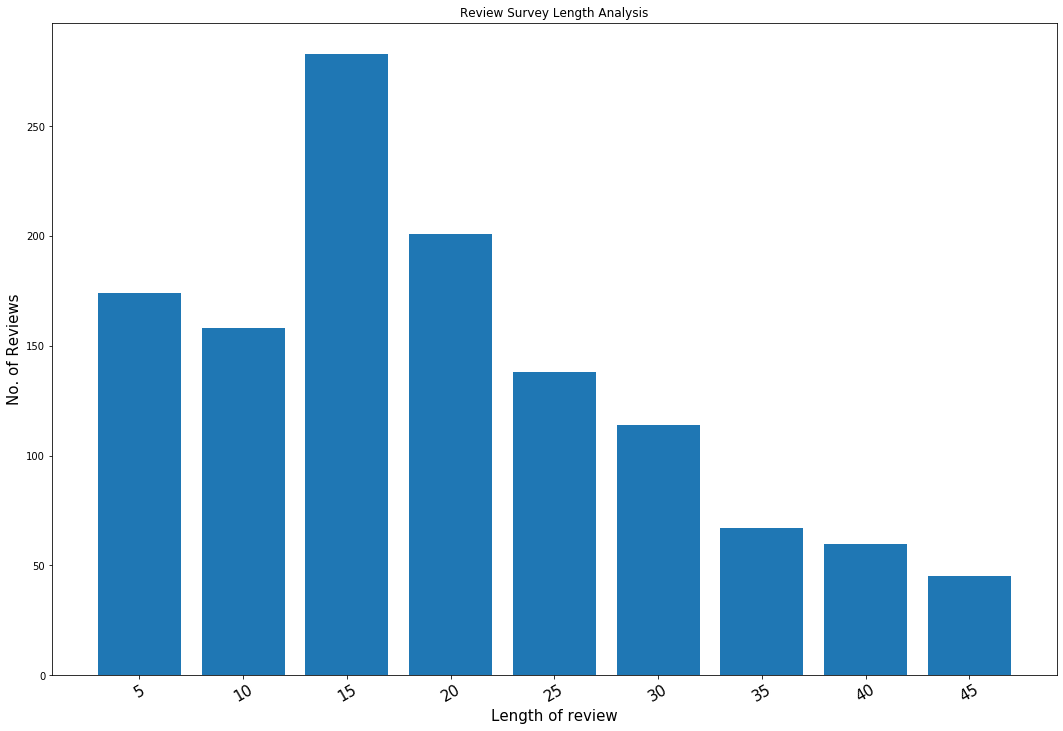

In [26]:
#Plot the review buckets
index = np.arange(len(checklen))
plt.bar(index,checklen)
plt.xlabel("Length of review",fontsize=15)
plt.ylabel("No. of Reviews",fontsize=15)
plt.xticks(index,range(5,50,5),fontsize=15,rotation=30)
plt.title("Review Survey Length Analysis")
plt.show()

### Feature Extraction

The objective is to extract relevance out of the text, and thus understanding in depth sense of the reviews. Feature extraction covers every necessary property/viewpoints and to measure features in a quantitative manner is a much needed task in order to achieve highly accurate outcomes.

#### 1. Noun Strength (Rn)

Nouns are subjects and considered as the most informative part of any language. The amount of subjects shows the importance of review because only a noun describes the prime factors of review. We will get the POS Tagging to find nouns in a review and compute the score as :

Score(Rn) = TfIDF(noun) / TfIDF(all words)


#### 2. Review Polarity (Rp)

With a value between -1 and +1 we can tell whether a review has positive or negative sentiment.

#### 3. Review Subjectivity (Rs)

This is a measure of the sentiment being objective or subjective and it takes values from 0 to 1. Objective expressions are facts while subjective expressions are opinions that describes someone's feelings e.g. 
- Bournvitta tastes really good with milk is **subjective**
- Bournvitta is brown in color is **objective**

#### 4. Review Complexity ( Rc)

To evaluate how good and complex a review is, in terms of unique words within a review and across an entire review corpus of a particular product.

Rc = Number of unique words in a Review / Number of unique words in an entire corpus

#### 5. Review Word Length (Rw)

This is the word count of the review

#### 6. Service Tagger (Rd)

The best review is one that talks more about the product, how it tastes, what are it's uses and the one talking about, how it is, what are it's uses, and the one that talks about the effectiveness of the product. Reviews should ideally describe the product. So a dictionary of words is created which would mark reviews as service-based, delivery reviews, customer support.

Fuzzy matching of every word in a review is done with the words in the dictionary with Levenshtein distance. Levenshtein distance helps in measuring the difference between two sequences and tackle spell errors in review, for example, instead of "My delivery was on time" a reviewer would enter "My dilivery was on time". In that case, Fuzzy matching would help us match both the reviews.

#### 7. Compound Score (Rsc)

To improve the efficiency of the system. The compund score is computed using VaderSentimentAnalyser. This library is taken from VADER (Valence Aware Dictionary and sEntiment Reasoner).

This is a lexicon and rule-based sentiment analysis tool that is  specifically tuned to determine sentiments expressed in social media content. It has the ability to find the sentiment of Slang (e.g. SUX!), Emoji, Emoticons and the difference between capitalised word expressions (I am SAD || I am sad )

Rsc >= 0.5 (Positive Sentiment)
-0.5<Rsc<+0.5(Neutral Sentiment)
Rsc<= -0.5(Negative Sentiment)

In [27]:
# Add feature columns
selected_reviews_df["Rn"] = 0.0
selected_reviews_df["Rp"] = 0.0
selected_reviews_df["Rs"] = 0.0
selected_reviews_df["Rc"] = 0.0
selected_reviews_df["Rd"] = 0.0
selected_reviews_df["Rsc"] = 0.0

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [28]:
selected_reviews_df.head()

name  \
1438   AmazonBasics AAA Performance Alkaline Batteries (36 Count)                                    
26133  Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers             
13634  Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Pink Kid-Proof Case                        
20256  All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Special Offers   
2116   AmazonBasics AAA Performance Alkaline Batteries (36 Count)                                    

       reviews.rating  \
1438   1                
26133  1                
13634  1                
20256  1                
2116   1                

                                                                 reviews.text  \
1438   Battery last long!                                                       
26133  my kids enjoy the Fire HD and they love the picture quality              
13634  My niece loved it! I love that it is designed especially for kids. She   
20256  Ordered this for my nephew and he loves it. Great Price too !!           
2116   Great                                                                    

       review_length   Rn   Rp   Rs   Rc   Rd  Rsc  
1438   3              0.0  0.0  0.0  0.0  0.0  0.0  
26133  12             0.0  0.0  0.0  0.0  0.0  0.0  
13634  14             0.0  0.0  0.0  0.0  0.0  0.0  
20256  13             0.0  0.0  0.0  0.0  0.0  0.0  
2116   1              0.0  0.0  0.0  0.0  0.0  0.0

In [29]:
# Get unique product list
product_list = selected_reviews_df["name"].unique()
product_list

array(['AmazonBasics AAA Performance Alkaline Batteries (36 Count)',
       'Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers',
       'Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Pink Kid-Proof Case',
       'All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Special Offers',
       'AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary',
       'All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black',
       'Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers',
       'Kindle E-reader - White, 6 Glare-Free Touchscreen Display, Wi-Fi - Includes Special Offers',
       'Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case',
       'Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case',
       'All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 3

In [30]:
# populate the features
for product in product_list:
    data = selected_reviews_df[selected_reviews_df["name"]==product]
    unique_bag = set()
    for review in data["reviews.text"]:
        review = review.lower()
        words = review.split()
        unique_bag = unique_bag.union(set(words))
        
    for indx in data.index:
        review = data.at[indx,"reviews.text"]
        selected_reviews_df.at[indx, "Rp"] = rf.polarity_sentiment(review)
        selected_reviews_df.at[indx, "Rs"] = rf.subjectivity_sentiment(review)
        selected_reviews_df.at[indx, "Rd"] = rf.service_tag(review)
        selected_reviews_df.at[indx, "Rsc"] = rf.slang_emoji_polarity_compoundscore(review)
        selected_reviews_df.at[indx, "Rc"] = float(len(set(review.split()))) / float(len(unique_bag))
        
    selected_reviews_df.loc[selected_reviews_df["name"]==product, "Rn"] = rf.noun_score(data["reviews.text"].values).values

E:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
E:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
E:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas

In [31]:
selected_reviews_df.head()

name  \
1438   AmazonBasics AAA Performance Alkaline Batteries (36 Count)                                    
26133  Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers             
13634  Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Pink Kid-Proof Case                        
20256  All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Special Offers   
2116   AmazonBasics AAA Performance Alkaline Batteries (36 Count)                                    

       reviews.rating  \
1438   1                
26133  1                
13634  1                
20256  1                
2116   1                

                                                                 reviews.text  \
1438   Battery last long!                                                       
26133  my kids enjoy the Fire HD and they love the picture quality              
13634  My niece loved it! I love that it is designed especially for kids. She   
20256  Ordered this for my nephew and he loves it. Great Price too !!           
2116   Great                                                                    

       review_length        Rn        Rp        Rs        Rc   Rd     Rsc  
1438   3              0.361438 -0.031250  0.233333  0.001744  0.0  0.0000  
26133  12             0.488242  0.450000  0.550000  0.011213  0.0  0.7184  
13634  14             0.344633  0.458333  0.800000  0.020115  1.0  0.8553  
20256  13             0.430650  1.000000  0.750000  0.022337  0.0  0.8550  
2116   1              0.000000  0.800000  0.750000  0.000581  0.0  0.6249

In [32]:
# Export the features into a csv file
selected_reviews_df.to_csv("./datasets/smaller_reviews_feature_sets.csv")

In [33]:
selected_reviews_df.shape

(1440, 10)

**With the derived features we have extracted the information required to build a ranking system. And we now proceed to model training.**

## Model Training

In [34]:
# create the features data frame from the stored features
reviews_feature_df = pd.read_csv('./datasets/smaller_reviews_feature_sets.csv')

In [35]:
reviews_feature_df.shape

(1440, 11)

In [36]:
reviews_feature_df.head(2)

Unnamed: 0  \
0  1438         
1  26133        

                                                                                name  \
0  AmazonBasics AAA Performance Alkaline Batteries (36 Count)                          
1  Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers   

   reviews.rating  \
0  1                
1  1                

                                                  reviews.text  review_length  \
0  Battery last long!                                           3               
1  my kids enjoy the Fire HD and they love the picture quality  12              

         Rn       Rp        Rs        Rc   Rd     Rsc  
0  0.361438 -0.03125  0.233333  0.001744  0.0  0.0000  
1  0.488242  0.45000  0.550000  0.011213  0.0  0.7184

In [37]:
# Re-arrange the dataframe to make it easier to filter the required data
reviews_feature_df = reviews_feature_df[["name","reviews.text","reviews.rating","review_length","Rn","Rp","Rs","Rc","Rd","Rsc"]]
reviews_feature_df.head(2)

name  \
0  AmazonBasics AAA Performance Alkaline Batteries (36 Count)                          
1  Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers   

                                                  reviews.text  \
0  Battery last long!                                            
1  my kids enjoy the Fire HD and they love the picture quality   

   reviews.rating  review_length        Rn       Rp        Rs        Rc   Rd  \
0  1               3              0.361438 -0.03125  0.233333  0.001744  0.0   
1  1               12             0.488242  0.45000  0.550000  0.011213  0.0   

      Rsc  
0  0.0000  
1  0.7184

#### Pairwise Ranking Vs Pairwise Comparison

1. **Pairwise Ranking** - Also known as preference ranking is a ranking tool used to assign priorities to the multiple available options. It is not possible for humans to analytically rank several reviews according to true preferences. This is why the ranking mechanism comes into play. All the options are directly compared to all the other options so that a list is created which consists of the most-preferred to the least preferred options. The pairwise ranking is a machine optimised procedure
2. **Pairwise Comparison** - This is the process of comparing alternatives in pairs to judge which entity is preferred over others or has a greater quantitative property

In [38]:
data_split = pd.crosstab(reviews_feature_df['name'],reviews_feature_df['reviews.rating'])
data_split

reviews.rating                                                                                                                                  0  \
name                                                                                                                                                
All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Blue Kid-Proof Case                                                               4     
All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Pink Kid-Proof Case                                                               5     
All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Special Offers                                                   11    
All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Marine Blue - with Special Offers                                                   2     
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black                                                         27    
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Blue                                                          2     
Amazon Tap Smart Assistant Alexaenabled (black) Brand New                                                                                     10    
AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary                                                                50    
AmazonBasics AAA Performance Alkaline Batteries (36 Count)                                                                                    129   
Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers                                                             43    
Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Tangerine - with Special Offers                                                             1     
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case                                                                        24    
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case                                                                       21    
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Pink Kid-Proof Case                                                                        34    
Fire Tablet with Alexa, 7 Display, 16 GB, Blue - with Special Offers                                                                          20    
Fire Tablet with Alexa, 7 Display, 16 GB, Magenta - with Special Offers                                                                       15    
Fire Tablet, 7 Display, Wi-Fi, 16 GB - Includes Special Offers, Black                                                                         16    
Kindle E-reader - White, 6 Glare-Free Touchscreen Display, Wi-Fi - Includes Special Offers                                                    9     
Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers  6     

reviews.rating                                                                                                                                  1  
name                                                                                                                                               
All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Blue Kid-Proof Case                                                               9    
All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Pink Kid-Proof Case                                                               10   
All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Special Offers                                                   35   
All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Marine Blue - with Special Offers                                       

In [39]:
# create the first set
set_one = reviews_feature_df[reviews_feature_df["reviews.rating"]==1]
set_one.head(2)

name  \
0  AmazonBasics AAA Performance Alkaline Batteries (36 Count)                          
1  Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers   

                                                  reviews.text  \
0  Battery last long!                                            
1  my kids enjoy the Fire HD and they love the picture quality   

   reviews.rating  review_length        Rn       Rp        Rs        Rc   Rd  \
0  1               3              0.361438 -0.03125  0.233333  0.001744  0.0   
1  1               12             0.488242  0.45000  0.550000  0.011213  0.0   

      Rsc  
0  0.0000  
1  0.7184

In [40]:
# add a join column to the first set
set_one.loc[reviews_feature_df["reviews.rating"]==1,"join"] = "j"

E:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [41]:
# view the first set
set_one.head(2)

name  \
0  AmazonBasics AAA Performance Alkaline Batteries (36 Count)                          
1  Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers   

                                                  reviews.text  \
0  Battery last long!                                            
1  my kids enjoy the Fire HD and they love the picture quality   

   reviews.rating  review_length        Rn       Rp        Rs        Rc   Rd  \
0  1               3              0.361438 -0.03125  0.233333  0.001744  0.0   
1  1               12             0.488242  0.45000  0.550000  0.011213  0.0   

      Rsc join  
0  0.0000  j    
1  0.7184  j

In [42]:
# create the second set
set_two = reviews_feature_df[reviews_feature_df["reviews.rating"]==0]
set_two.head(2)

name  \
7   All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black   
19  AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary          

                                                                                                                                                                                                                                                                                                                                      reviews.text  \
7   I really was looking for a simple, cheap tablet to play games and mess around on. Screen is really nice and it serves it's purpose well. Video and games both work really well on them. The only real negative about the tablet is that the cameras are not good. I really don't need them so I don't use them and it's not a big deal for me.   
19  Theyre batteries they either work or they don't, how long do they last I don't know I just got them at Christmas !!                                                                                                                                                                                                                              

    reviews.rating  review_length        Rn        Rp        Rs        Rc  \
7   0               67             0.544678  0.056818  0.466558  0.053905   
19  0               23             0.075324 -0.025000  0.233333  0.018692   

     Rd     Rsc  
7   1.0  0.0976  
19  1.0  0.0000

In [43]:
# add a join column to the second set
set_two.loc[reviews_feature_df["reviews.rating"]==0,"join"] = "j"
set_two.head(2)

name  \
7   All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black   
19  AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary          

                                                                                                                                                                                                                                                                                                                                      reviews.text  \
7   I really was looking for a simple, cheap tablet to play games and mess around on. Screen is really nice and it serves it's purpose well. Video and games both work really well on them. The only real negative about the tablet is that the cameras are not good. I really don't need them so I don't use them and it's not a big deal for me.   
19  Theyre batteries they either work or they don't, how long do they last I don't know I just got them at Christmas !!                                                                                                                                                                                                                              

    reviews.rating  review_length        Rn        Rp        Rs        Rc  \
7   0               67             0.544678  0.056818  0.466558  0.053905   
19  0               23             0.075324 -0.025000  0.233333  0.018692   

     Rd     Rsc join  
7   1.0  0.0976  j    
19  1.0  0.0000  j

In [44]:
# create the first pairwise training set
train_set_one = pd.merge(set_one,set_two,how='outer',on='join')
train_set_one.shape

(433719, 21)

In [45]:
# view the first pairwise training set
train_set_one.head(2)

name_x  \
0  AmazonBasics AAA Performance Alkaline Batteries (36 Count)   
1  AmazonBasics AAA Performance Alkaline Batteries (36 Count)   

       reviews.text_x  reviews.rating_x  review_length_x      Rn_x     Rp_x  \
0  Battery last long!  1                 3                0.361438 -0.03125   
1  Battery last long!  1                 3                0.361438 -0.03125   

       Rs_x      Rc_x  Rd_x  Rsc_x  ...  \
0  0.233333  0.001744  0.0   0.0    ...   
1  0.233333  0.001744  0.0   0.0    ...   

                                                                                  name_y  \
0  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black   
1  AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary          

                                                                                                                                                                                                                                                                                                                                   reviews.text_y  \
0  I really was looking for a simple, cheap tablet to play games and mess around on. Screen is really nice and it serves it's purpose well. Video and games both work really well on them. The only real negative about the tablet is that the cameras are not good. I really don't need them so I don't use them and it's not a big deal for me.   
1  Theyre batteries they either work or they don't, how long do they last I don't know I just got them at Christmas !!                                                                                                                                                                                                                              

  reviews.rating_y  review_length_y      Rn_y      Rp_y      Rs_y      Rc_y  \
0  0                67               0.544678  0.056818  0.466558  0.053905   
1  0                23               0.075324 -0.025000  0.233333  0.018692   

   Rd_y   Rsc_y  
0  1.0   0.0976  
1  1.0   0.0000  

[2 rows x 21 columns]

In [46]:
# create the second pairwise training set
train_set_two = pd.merge(set_two,set_one,how='outer',on ='join')
train_set_two.shape

(433719, 21)

In [47]:
# view the second pairwise training set
train_set_two.head(2)

name_x  \
0  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black   
1  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black   

                                                                                                                                                                                                                                                                                                                                   reviews.text_x  \
0  I really was looking for a simple, cheap tablet to play games and mess around on. Screen is really nice and it serves it's purpose well. Video and games both work really well on them. The only real negative about the tablet is that the cameras are not good. I really don't need them so I don't use them and it's not a big deal for me.   
1  I really was looking for a simple, cheap tablet to play games and mess around on. Screen is really nice and it serves it's purpose well. Video and games both work really well on them. The only real negative about the tablet is that the cameras are not good. I really don't need them so I don't use them and it's not a big deal for me.   

   reviews.rating_x  review_length_x      Rn_x      Rp_x      Rs_x      Rc_x  \
0  0                 67               0.544678  0.056818  0.466558  0.053905   
1  0                 67               0.544678  0.056818  0.466558  0.053905   

   Rd_x   Rsc_x  ...  \
0  1.0   0.0976  ...   
1  1.0   0.0976  ...   

                                                                              name_y  \
0  AmazonBasics AAA Performance Alkaline Batteries (36 Count)                          
1  Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers   

                                                reviews.text_y  \
0  Battery last long!                                            
1  my kids enjoy the Fire HD and they love the picture quality   

  reviews.rating_y  review_length_y      Rn_y     Rp_y      Rs_y      Rc_y  \
0  1                3                0.361438 -0.03125  0.233333  0.001744   
1  1                12               0.488242  0.45000  0.550000  0.011213   

   Rd_y   Rsc_y  
0  0.0   0.0000  
1  0.0   0.7184  

[2 rows x 21 columns]

In [48]:
# merge the two pairwise training sets
train_set = pd.merge(train_set_one,train_set_two,how='outer')
train_set.shape

(867438, 21)

In [49]:
# This function helps to build the training data by consolidating the above steps
def building_training_data(df):
    A = df[df['reviews.rating']==1]    
    A.loc[df['reviews.rating']==1,'join'] = 'j'
    B = df[df['reviews.rating']==0]
    B.loc[df['reviews.rating']==0,'join'] = 'j'
    trainset1 = pd.merge(A,B,how='outer',on='join')
    trainset2 = pd.merge(B,A,how='outer',on ='join')

    trainset = pd.merge(trainset1,trainset2,how='outer')
    return trainset

In [50]:
# predicting the target variable for classification purposes
product_list = reviews_feature_df['name'].unique()
data_stack = []
for product in product_list:    
    temp = deepcopy(reviews_feature_df[reviews_feature_df['name']==product].iloc[:,2:])
    build_data = building_training_data(temp)    
    print(product, len(temp), len(build_data))
    build_data.drop(columns = ['join','reviews.rating_y'],inplace=True)
    data = build_data.iloc[:,1:]
    data['target'] = build_data.iloc[:,0]
    data_stack.append(data)

AmazonBasics AAA Performance Alkaline Batteries (36 Count) 449 82560
Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers 125 7052
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Pink Kid-Proof Case 86 3536
All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Special Offers 46 770
AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary 183 13300
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black 114 4698
Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers 30 288
Kindle E-reader - White, 6 Glare-Free Touchscreen Display, Wi-Fi - Includes Special Offers 18 162
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case 67 1932
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case 76 2496
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special O

In [51]:
# create the training dataframe
train = pd.concat(data_stack).reset_index(drop = True)

In [52]:
train.shape

(121402, 15)

In [53]:
train.head(2)

review_length_x      Rn_x     Rp_x      Rs_x      Rc_x  Rd_x  Rsc_x  \
0  3                0.361438 -0.03125  0.233333  0.001744  0.0   0.0     
1  3                0.361438 -0.03125  0.233333  0.001744  0.0   0.0     

   review_length_y      Rn_y      Rp_y      Rs_y      Rc_y  Rd_y   Rsc_y  \
0  13               0.259413  0.216667  0.355556  0.007558  1.0   0.4404   
1  72               0.507304 -0.210000  0.493333  0.034884  1.0  -0.6792   

   target  
0  1       
1  1

In [54]:
# splitting the data in readiness of classification
X = train.iloc[:,:-1].values
y = train.iloc[:,-1].values

In [55]:
X

array([[ 3.00000000e+00,  3.61438155e-01, -3.12500000e-02, ...,
         7.55813953e-03,  1.00000000e+00,  4.40400000e-01],
       [ 3.00000000e+00,  3.61438155e-01, -3.12500000e-02, ...,
         3.48837209e-02,  1.00000000e+00, -6.79200000e-01],
       [ 3.00000000e+00,  3.61438155e-01, -3.12500000e-02, ...,
         2.61627907e-02,  1.00000000e+00,  8.84700000e-01],
       ...,
       [ 3.00000000e+01,  6.09541378e-02,  2.37500000e-01, ...,
         9.55414013e-02,  1.00000000e+00,  8.57800000e-01],
       [ 3.00000000e+01,  6.09541378e-02,  2.37500000e-01, ...,
         1.84713376e-01,  1.00000000e+00,  8.82500000e-01],
       [ 3.00000000e+01,  6.09541378e-02,  2.37500000e-01, ...,
         2.99363057e-01,  1.00000000e+00,  9.51300000e-01]])

In [56]:
y

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [57]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,shuffle = True, stratify = y) 
print("Test Len:",len(X_test)," ",len(y_test))

Test Len: 24281   24281


In [58]:
train

review_length_x      Rn_x      Rp_x      Rs_x      Rc_x  Rd_x   Rsc_x  \
0       3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
1       3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
2       3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
3       3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
4       3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
5       3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
6       3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
7       3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
8       3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
9       3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
10      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
11      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
12      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
13      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
14      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
15      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
16      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
17      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
18      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
19      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
20      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
21      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
22      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
23      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
24      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
25      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
26      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
27      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
28      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
29      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
30      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
31      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
32      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
33      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
34      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
35      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
36      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
37      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
38      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
39      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
40      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
41      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
42      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
43      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
44      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
45      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
46      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
47      3                0.361438 -0.031250  0.233333  0.001744  0.0   0.0000   
48      3                0.361438 -0.03

### Modeling using Logistic Regression

In [61]:
lg_classifier = LogisticRegression()
lg_classifier.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [63]:
print("Training Accuracy\n", accuracy_score(y_train,lg_classifier.predict(X_train)))

Training Accuracy
 0.7615448770090918


In [64]:
print("Test Accuracy\n", accuracy_score(y_test,lg_classifier.predict(X_test)))

Test Accuracy
 0.76100654832997


In [66]:
print('CLASSIFICATION REPORT')
print("Training\n", classification_report(y_train,lg_classifier.predict(X_train)))

CLASSIFICATION REPORT
Training
               precision    recall  f1-score   support

           0       0.76      0.76      0.76     48561
           1       0.76      0.76      0.76     48560

    accuracy                           0.76     97121
   macro avg       0.76      0.76      0.76     97121
weighted avg       0.76      0.76      0.76     97121



In [67]:
print('CLASSIFICATION REPORT')
print("Test \n", classification_report(y_test,lg_classifier.predict(X_test)))

CLASSIFICATION REPORT
Test 
               precision    recall  f1-score   support

           0       0.76      0.76      0.76     12140
           1       0.76      0.76      0.76     12141

    accuracy                           0.76     24281
   macro avg       0.76      0.76      0.76     24281
weighted avg       0.76      0.76      0.76     24281



### Modeling using Decision Trees

In [68]:
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [69]:
print("Training Accuracy\n", accuracy_score(y_train,dt_classifier.predict(X_train)))

Training Accuracy
 0.9994645854140711


In [70]:
print("Test Accuracy\n", accuracy_score(y_test,dt_classifier.predict(X_test)))

Test Accuracy
 0.9935752234257238


In [71]:
print('CLASSIFICATION REPORT')
print("Training\n", classification_report(y_train,dt_classifier.predict(X_train)))

CLASSIFICATION REPORT
Training
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     48561
           1       1.00      1.00      1.00     48560

    accuracy                           1.00     97121
   macro avg       1.00      1.00      1.00     97121
weighted avg       1.00      1.00      1.00     97121



In [72]:
print('CLASSIFICATION REPORT')
print("Test \n", classification_report(y_test,dt_classifier.predict(X_test)))

CLASSIFICATION REPORT
Test 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     12140
           1       0.99      0.99      0.99     12141

    accuracy                           0.99     24281
   macro avg       0.99      0.99      0.99     24281
weighted avg       0.99      0.99      0.99     24281



### Modeling using Random Forest

In [73]:
rf_classifier = RandomForestClassifier(n_estimators=50, n_jobs = -1, oob_score = True,random_state=42)
rf_classifier.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [74]:
print("Training Accuracy\n", accuracy_score(y_train,rf_classifier.predict(X_train)))

Training Accuracy
 0.9994645854140711


In [75]:
print("Test Accuracy\n", accuracy_score(y_test,rf_classifier.predict(X_test)))

Test Accuracy
 0.9982702524607718


In [76]:
print('CLASSIFICATION REPORT')
print("Training\n", classification_report(y_train,rf_classifier.predict(X_train)))

CLASSIFICATION REPORT
Training
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     48561
           1       1.00      1.00      1.00     48560

    accuracy                           1.00     97121
   macro avg       1.00      1.00      1.00     97121
weighted avg       1.00      1.00      1.00     97121



In [77]:
print('CLASSIFICATION REPORT')
print("Test \n", classification_report(y_test,rf_classifier.predict(X_test)))


CLASSIFICATION REPORT
Test 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     12140
           1       1.00      1.00      1.00     12141

    accuracy                           1.00     24281
   macro avg       1.00      1.00      1.00     24281
weighted avg       1.00      1.00      1.00     24281



In [79]:
print('CONFUSION MATRIX')
print("Test\nConfusion Matrix: \n", confusion_matrix(y_test, rf_classifier.predict(X_test)))

CONFUSION MATRIX
Test
Confusion Matrix: 
 [[12123    17]
 [   25 12116]]


In [80]:
## Score of the training dataset obtained using an out-of-bag estimate. This attribute exists only when oob_score is True.
rf_classifier.oob_score_

0.9971169983834598

In [81]:
# Check the feature importance
feature_importances = pd.DataFrame(rf_classifier.feature_importances_,
                                   index = train.iloc[:,:-1].columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

importance
Rsc_y            0.181445  
Rsc_x            0.161879  
Rp_y             0.095382  
Rp_x             0.093917  
Rn_y             0.063986  
Rc_y             0.062716  
Rs_y             0.060089  
Rc_x             0.057275  
Rn_x             0.056984  
review_length_y  0.053386  
Rs_x             0.051979  
review_length_x  0.046311  
Rd_x             0.007402  
Rd_y             0.007248

In [82]:
# Save the model
dump(rf_classifier, './pickles/pairwise-classification-of-amazon-products-randomforest-v1.pkl', compress = 2)

['./pickles/pairwise-classification-of-amazon-products-randomforest-v1.pkl']

## Using the Saved Model

We would wish to have all the reviews ranked to be relevant to appear above those reviews that have been ranked as not relevant. To test this hypothesis, i used the below formula where x is the total number of 1s

### `Ranking Accuracy on Single Product = Number of 1s found in first x positions / x`

In [83]:
# Load the classifier
classifier = load('./pickles/pairwise-classification-of-amazon-products-randomforest-v1.pkl')

In [84]:
# Get the list of products
product_list = selected_reviews_df['name'].unique()

In [88]:
# Create new columns

# This is the number of times the product was reviewed as relevant
selected_reviews_df['win']=0 

# This is the number of times the product was reviewed as not relevant 
selected_reviews_df['lose']=0

# this is equal to the number of times the product was considered as relevant divided by the number of time the 
# total number of relevant reviews
selected_reviews_df['review_score'] = 0.0 

selected_reviews_df.reset_index(inplace = True, drop = True)

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas

In [89]:
# function to generate the score with the saved model
def score_giver(C,D):
    E = pd.merge(C,D,how='outer',on='j')
    E.drop(columns=['j'],inplace = True)
    q= rf_classifier.predict(E.values)
    return Counter(q)

In [91]:
# generate the scores
for product in product_list:
    data = selected_reviews_df[selected_reviews_df['name']==product]
    for indx in data.index:
        review = selected_reviews_df.iloc[indx, 3:-3]
        review['j'] = 'jn'
        C = pd.DataFrame([review])
        D = data[data.index!=indx].iloc[:,3:-3]
        D['j'] = 'jn'
        score = score_giver(C,D)
        selected_reviews_df.at[indx, 'win'] = 0 if score.get(1) is None else score.get(1)
        selected_reviews_df.at[indx, 'lose'] = 0 if score.get(0) is None else score.get(0)
        selected_reviews_df.at[indx, 'review_score'] = float(0 if score.get(1) is None else score.get(1)) / len(data) * 1.0

In [92]:
# sort by relevance
selected_reviews_df = selected_reviews_df.sort_values(by = ['name','review_score'], ascending = False)

In [94]:
# calculate the accuracy
r_accuracy =[]
for product in product_list:
    x = data_split[data_split.index == product][1][0]
    number_of_1_in_x = Counter(selected_reviews_df[selected_reviews_df['name']==product].iloc[:x, ]['reviews.rating']).get(1)
    rank_accuracy = float(number_of_1_in_x*1.0 / x*1.0)
    print("Product: {} | Rank Accuracy: {}".format(product, rank_accuracy))
    r_accuracy.append(rank_accuracy)
print("Mean Rank Accuracy: {}".format(mean(r_accuracy)))

Product: AmazonBasics AAA Performance Alkaline Batteries (36 Count) | Rank Accuracy: 0.9875
Product: Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers | Rank Accuracy: 1.0
Product: Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Pink Kid-Proof Case | Rank Accuracy: 1.0
Product: All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Special Offers | Rank Accuracy: 1.0
Product: AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary | Rank Accuracy: 0.9924812030075187
Product: All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black | Rank Accuracy: 1.0
Product: Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers | Rank Accuracy: 0.9583333333333334
Product: Kindle E-reader - White, 6 Glare-Free Touchscreen Display, Wi-Fi - Includes Special Offers | Rank Accuracy: 1.0
Product: Fire Kids Edition

In [95]:
selected_reviews_df

name  \
9     Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
1038  Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
697   Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
1012  Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
1391  Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
954   Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
1041  Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
250   Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
778   Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
1052  Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
152   Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
223   Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
1264  Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
255   Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
1295  Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
316   Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
530   Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
562   Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
1266  Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
896   Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
744   Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
1384  Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
857   Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
1399  Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
1403  Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
1039  Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
196   Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Lig

In [96]:
ranked_reviews_df = selected_reviews_df[["name","reviews.text","review_score"]]
ranked_reviews_df

name  \
9     Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
1038  Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
697   Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
1012  Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
1391  Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
954   Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
1041  Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
250   Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
778   Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
1052  Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
152   Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
223   Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
1264  Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
255   Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
1295  Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
316   Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
530   Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
562   Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
1266  Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
896   Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
744   Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
1384  Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
857   Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
1399  Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
1403  Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
1039  Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers   
196   Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Lig

In [97]:
# save the product name, the review text and the accuracy score into a seperate excel sheet
ranked_reviews_df.to_csv('./ranked/train_ranked_output.csv',index = False)